In [1]:
import inspect
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import importlib.util


import sys
import os

import torch
from torch.utils.data import DataLoader
from torch.optim import LBFGS


## Evolution Enhanced Feature Maps

Starting from paper: https://arxiv.org/abs/2011.10395

After the set of single qubit rotations (dataencoding), we consider another unitary exp(-iH$\tau$) which acts for time $\tau$ and is generated by the Hamiltonian $H$.
$H$ is chosen to be a complex many body Hamiltonian, to ensure that exponentially many amplitudes are generated.
(Additionally, we plan an evolution layer that is parameter dependent_ $\tau\rightarrow\tau(x)$.)

#### Differential Equations with highly nontrivial dynamics

$$\frac{\partial^2 u}{\partial x^2}=1 ~~~\text{with b.c.}~~~ u(x=-1)=u(x=1)=0 \\
\rightarrow u(x)=\frac{1}{2}(x^2-1)$$

For now: we chose a nearest neighbor Ising Hamiltonian $H=-J\sum_jZ_jZ_{j+1}+h\sum_jX_j$ with a fixed evolution time $\tau=2$ and J and h being drawn uniformly from (0,1].

We use AdamOptimizer with lr=0.01 & 200 operations. Set $u_0=0.75$ and train with 100 points. Cost choice of total magnetization in the $z-$direction ($\hat{C}\sum_jZ_j$) and a Hardware-Efficient Ansatz of depth=6 is used. 

#### Defining the Hamiltonian

In [2]:
n_qubits = 6

J = np.random.rand(1)
h = np.random.rand(1) 

obs1 = [qml.PauliZ(j)@qml.PauliZ(j+1) for j in range(n_qubits-1)]
obs2 = [qml.PauliX(j) for j in range(n_qubits)]

coeffs1 = [J for i in range(n_qubits-1)]
coeffs2 = [h for i in range(n_qubits)]

obs = obs1 + obs2
coeffs = coeffs1 + coeffs2

H = qml.Hamiltonian(coeffs, obs)

print(H)

  ([0.532888]) [X0]
+ ([0.532888]) [X1]
+ ([0.532888]) [X2]
+ ([0.532888]) [X3]
+ ([0.532888]) [X4]
+ ([0.532888]) [X5]
+ ([0.50951473]) [Z0 Z1]
+ ([0.50951473]) [Z1 Z2]
+ ([0.50951473]) [Z2 Z3]
+ ([0.50951473]) [Z3 Z4]
+ ([0.50951473]) [Z4 Z5]


#### Defining the Tower Chebyshev feature maps

In [3]:
n_qubits = 6
depth = 5
layers = 1

dev = qml.device("default.qubit", wires = n_qubits)

# parameters #
tau = 2  # evolution time
n = 10 # order of trotterization 

# Hamiltonian
J = np.random.rand(1)
h = np.random.rand(1) 

obs1 = [qml.PauliZ(j)@qml.PauliZ(j+1) for j in range(n_qubits-1)]
obs2 = [qml.PauliX(j) for j in range(n_qubits)]
coeffs1 = [J for i in range(n_qubits-1)]
coeffs2 = [h for i in range(n_qubits)]
obs = obs1 + obs2
coeffs = coeffs1 + coeffs2

H = qml.Hamiltonian(coeffs, obs)

# end parameters#


# Define possible feature maps

# Tower Chebyshev feature map
def TChebyshev(x):
    for layer in range(layers):
        for i in range(n_qubits):
            qml.RY(2*i*torch.arccos(x), wires=i)



# Evolution ehanced feature map
def EvolutionEnhanced(x, H, tau = 2, n = 10):
    TChebyshev(x)
    qml.ApproximateTimeEvolution(H, tau, n)


# Define the Hardware-Efficient Ansatz
def HardwareEffAnsatz(params):
    for d in range(depth):
        for l in range(n_qubits):
            qml.RZ(params[l,0, d], wires=l)
            qml.RX(params[l,1, d], wires=l) 
            qml.RZ(params[l,2, d], wires=l)
        for l in range(0, n_qubits-1, 2):
            qml.CNOT(wires=[l,l+1])
        for l in range(1, n_qubits-1, 2):
            qml.CNOT(wires=[l,l+1])
        

@qml.qnode(dev, interface="torch")
def VQA_TC(inputs, params):
    TChebyshev(inputs)
    HardwareEffAnsatz(params)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)] # Use total magnetization as cost function
 

weight_shapes = {"params": (n_qubits, 3, depth)}
layer = qml.qnn.TorchLayer(VQA_TC, weight_shapes)
model = torch.nn.Sequential(layer)



cost function: differential equation!

In [4]:
def compute_output(outs):
    return torch.mean(outs)

def residual(controlPoints):
        """ Calculate the residium of the control points"""
        x = controlPoints
        u = compute_output(model(x))
        
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]

        f = u_xx - 1
    
        return f

def cost(points):
    x = points[0]
    xBdr = points[1]
    BdrValue = 0
    residualLoss = residual(x)**2
    boundaryLoss = (BdrValue - compute_output(model(xBdr)))**2
    return residualLoss + boundaryLoss



In [169]:
num_train_point = 400
controlPoints = torch.rand(num_train_point, requires_grad=True)
controlPointsBdr = torch.tensor([-1,1]*int(num_train_point/2))

batches = torch.utils.data.DataLoader(torch.stack((controlPoints, controlPointsBdr),dim=1), batch_size=25, shuffle=True)


In [170]:
opt = torch.optim.Adam(model.parameters(), lr=1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)
steps = 100
model.train()

for i in range(steps):
    for batch in batches:
        loss = 0
        opt.zero_grad()
        for x in batch:
            loss += cost(x)
        loss=loss/len(batch)
        loss.backward(retain_graph=True)
        opt.step()
    #scheduler.step()
    if i%10==0:
        print("step: ", i, "--> loss = ", loss)

step:  0 --> loss =  tensor(6.3115, grad_fn=<DivBackward0>)
step:  10 --> loss =  tensor(0.5523, grad_fn=<DivBackward0>)
step:  20 --> loss =  tensor(0.2127, grad_fn=<DivBackward0>)
step:  30 --> loss =  tensor(0.2029, grad_fn=<DivBackward0>)
step:  40 --> loss =  tensor(0.1909, grad_fn=<DivBackward0>)
step:  50 --> loss =  tensor(0.1978, grad_fn=<DivBackward0>)
step:  60 --> loss =  tensor(0.1959, grad_fn=<DivBackward0>)
step:  70 --> loss =  tensor(0.1959, grad_fn=<DivBackward0>)
step:  80 --> loss =  tensor(0.1894, grad_fn=<DivBackward0>)
step:  90 --> loss =  tensor(0.1965, grad_fn=<DivBackward0>)


In [165]:
def exactSolution(x):
    return 1/2*(x**2-1)

tensor([[-1.0000],
        [-0.8000],
        [-0.6000],
        [-0.4000],
        [-0.2000],
        [ 0.0000],
        [ 0.2000],
        [ 0.4000],
        [ 0.6000],
        [ 0.8000],
        [ 1.0000]], dtype=torch.float64)
[tensor(-1., dtype=torch.float64), tensor(-0.8000, dtype=torch.float64), tensor(-0.6000, dtype=torch.float64), tensor(-0.4000, dtype=torch.float64), tensor(-0.2000, dtype=torch.float64), tensor(0., dtype=torch.float64), tensor(0.2000, dtype=torch.float64), tensor(0.4000, dtype=torch.float64), tensor(0.6000, dtype=torch.float64), tensor(0.8000, dtype=torch.float64), tensor(1., dtype=torch.float64)]


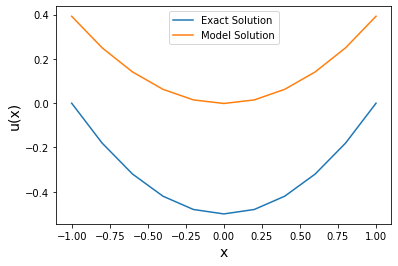

In [171]:
# Create plot Points
numPlotPoints = 11

plotPoints = np.linspace(-1, 1, numPlotPoints).reshape(numPlotPoints, 1)
yExact = exactSolution(plotPoints)
print(torch.tensor(plotPoints))
print([Point[0] for Point in torch.tensor(plotPoints)])
yModel = [compute_output(model(Point[0])).detach().numpy() for Point in torch.tensor(plotPoints)]

plt.plot(plotPoints, yExact, label = "Exact Solution")
plt.plot(plotPoints, yModel, label = "Model Solution")
plt.xlabel("x", fontsize=14)
plt.ylabel("u(x)", fontsize=14)
plt.legend()
#plt.savefig("ModelFit.png")

plt.show()

### Compute damped oscillator

$$\frac{du}{dx}+\lambda u(\kappa+\tan(\lambda\kappa))=0, ~~~~ u(0)=u_0$$

This has a solution in the form of damped oscillating function 

$$u(x)=\exp(-\kappa\lambda x)\cos(\lambda x)+ const$$

In [16]:
lamda_ = 8 #20
kappa = 0.1
u_0 = 1

def solutionDampedOscillator(x):
    y = 1/2*np.exp(-kappa*lamda_*x)*np.cos(lamda_*x) +  (1-u_0)
    return y 

def compute_output(outs):
    return torch.mean(outs)

def residual(controlPoints, lamda_=lamda_, kappa=kappa):
        """ Calculate the residium of the control points"""
        x = controlPoints
        u = compute_output(model(x))
        
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]

        
        
        f = u_x + lamda_*u*(kappa + torch.tan(lamda_*x))
    
        return f

def cost(points):
    x = points[0]
    xInit = points[1]
    InitValue = 0.75
    residualLoss = residual(x)**2
    initLoss = (InitValue - compute_output(model(xInit)))**2
    return residualLoss + 0.1*initLoss



In [17]:
num_train_point = 20
#controlPoints = torch.rand(num_train_point, requires_grad=True)
controlPoints = torch.linspace(0,0.9,20,  requires_grad=True)
controlPointsBdr = torch.tensor([-1,1]*int(num_train_point/2))

batches = torch.utils.data.DataLoader(torch.stack((controlPoints, controlPointsBdr),dim=1), batch_size=1, shuffle=True)

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)
steps = 100
model.train()

for i in range(steps):
    for batch in batches:
        loss = 0
        opt.zero_grad()
        for x in batch:
            loss += cost(x)
        loss=loss/len(batch)
        loss.backward(retain_graph=True)
        opt.step()
    #scheduler.step()
    if i%10==0:
        print("step: ", i, "--> loss = ", loss)

step:  0 --> loss =  tensor(0.0709, grad_fn=<DivBackward0>)
step:  10 --> loss =  tensor(0.0712, grad_fn=<DivBackward0>)


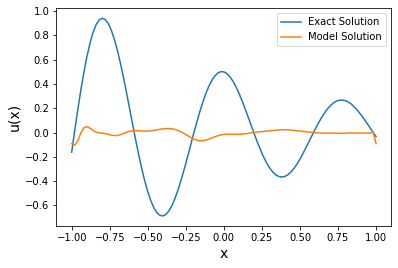

In [15]:
numPlotPoints = 101

plotPoints = np.linspace(-1, 1, numPlotPoints).reshape(numPlotPoints, 1)
yExact = solutionDampedOscillator(plotPoints)
yModel = [compute_output(model(Point[0])).detach().numpy() for Point in torch.tensor(plotPoints)]



plt.plot(plotPoints, yExact, label = "Exact Solution")
plt.plot(plotPoints, yModel, label = "Model Solution")
plt.xlabel("x", fontsize=14)
plt.ylabel("u(x)", fontsize=14)
plt.legend()
#plt.savefig("ModelFit.png")

plt.show()

### Consider a rapidly oscillating non-persiodic solution.
Initial Value problem:
$$\frac{du}{dx}-4u+6u^2-sin(50x)-ucos(25x)+1/2 = 0, ~~~~~~ u(0)=u_0$$

In [140]:
def compute_output(outs):
    return torch.mean(outs)

def residual(controlPoints):
        """ Calculate the residium of the control points"""
        x = controlPoints
        u = compute_output(model(x))
        
        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True,
            allow_unused=True
        )[0]

        f = u_x - 4*u + 6*u**2 - torch.sin(50*x) - u*torch.cos(25*x) + 1/2
    
        return f

def cost(points):
    x = points[0]
    xInit = points[1]
    InitValue = 0.75
    residualLoss = residual(x)**2
    initLoss = (InitValue - compute_output(model(xInit)))**2
    return residualLoss + initLoss

